## Imports

In [ ]:
# !rm -rf glo-flow

In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (281/281), done.
remote: Total 435 (delta 260), reused 310 (delta 140), pack-reused 0
Receiving objects: 100% (435/435), 971.35 KiB | 4.48 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [ ]:
import sys
sys.path.append('/content/glo-flow')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/glo-flow']

In [ ]:
!pip install -q nflows comet_ml
!pip install -q git+https://github.com/VLL-HD/FrEIA.git

     |████████████████████████████████| 45 kB 1.5 MB/s 
     |████████████████████████████████| 315 kB 7.2 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 548 kB 13.2 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from comet_ml import Experiment
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

from tqdm.notebook import tqdm
from collections import Counter

from modules.dataset import IdxDataset, LatentsDataset, LatentsContextualDataset
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.loss import LapLoss, ValLoss
from modules.visualization import img_side_by_side, visualize_image_grid, img_raw_by_raw

import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [ ]:
BW_METHOD = 0.1
N_COMPONENTS = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Dataset

In [ ]:
dataset_train = IdxDataset(CIFAR10(root='datasets', train=True, transform=transforms.ToTensor(), download=True))
# subset_idx = torch.randint(low=0, high=len(dataset_train), size=(5_000, ))
# subset = torch.utils.data.Subset(dataset_train, subset_idx)

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=False)
# subset_loader = DataLoader(subset, batch_size=64, shuffle=False)
len(dataset_train) #, len(subset)

Files already downloaded and verified


50000

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([64, 3, 32, 32])

## Generator

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
generator = GLOGenerator(min_channels=128,
                         max_channels=1024,
                         latent_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sample_generator, sparse=True).to(device)

In [ ]:
g_optimizer = torch.optim.Adam(model.generator.parameters(), lr=1e-3)
g_scheduler = None
z_optimizer = torch.optim.SparseAdam(params=model.z.parameters(), lr=1e-3)
z_scheduler = None #torch.optim.lr_scheduler.StepLR(z_optimizer, step_size=130, gamma=0.2)

## Flow model from FrEIA

In [ ]:
def subnet_fc(dims_in, dims_out):
    middle_dim = 256
    fc1 = nn.Linear(dims_in, middle_dim)
    torch.nn.init.xavier_normal_(fc1.weight)
    fc2 = nn.Linear(middle_dim, dims_out)
    torch.nn.init.zeros_(fc2.weight)
    
    return nn.Sequential(fc1, nn.ReLU(), fc2)

In [ ]:
N = 100
flow = Ff.SequenceINN(N_COMPONENTS)
for k in range(N):
    flow.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
    if k < N-1:
        flow.append(Fm.PermuteRandom) #inn.append(Fm.OrthogonalTransform)
_ = flow.to(device)

In [ ]:
flow_optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
flow_scheduler = None #torch.optim.lr_scheduler.MultiStepLR(flow_optimizer, [50, 100], gamma=0.2)

## Training pipeline

In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='joint-cifar',
                        workspace='alexandernevarko',
                        auto_metric_logging=False)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/joint-cifar/7526be65b5844539b81022e1766ac351
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average flow epoch train loss      : nan
COMET INFO:     Average generator epoch train loss : nan
COMET INFO:     FID                                : 195.6774698480551
COMET INFO:     IS                                 : 2.7364888191223145
COMET INFO:     Train flow loss [9]                : (-0.9419072866439819, 5.982851028442383)
COMET INFO:     Train generator loss [9]           : (0.16235555708408356, 0.18193697929382324)
COMET INFO:   Others:
COMET INFO:     Name         : alpha_0.2_gen_4_laploss3_test_set
COMET INFO:     notebook_url : https://colab.research.go

In [ ]:
g_criterion = LapLoss(max_levels=3, channels=3, size=3, device=device)
val_loss = ValLoss(device)

In [ ]:
# experiment = None

def bad_loss(loss):
    return (loss > 10) or torch.isnan(loss) or torch.isinf(loss)

exp_name = 'alpha_0.5_gen_4_laploss3_test_set'
model_path = '/content/drive/MyDrive/GLANN/joint_cifar_models'
n_epochs = 501
if experiment is not None:
    experiment.set_name(exp_name)
img_num = 16 # number of images to log
alpha = 0.5 # Factor of flow gradient
cnt = Counter()
clipping_value = 1e-4 # for gradient clipping
best_epoch_loss = np.inf

for epoch in tqdm(range(n_epochs)):
    flow.train()
    model.train()
    gen_running_loss = []
    flow_running_loss = []
    for i, (idx, img, _) in enumerate(tqdm(train_loader, leave=False)):
        idx, img = idx.long().to(device), img.float().to(device)
        
        g_optimizer.zero_grad()
        z_optimizer.zero_grad()
        flow_optimizer.zero_grad()
        # Generator forward pass
        preds = model(idx=idx)
        loss = g_criterion(preds, img)
        loss.backward(retain_graph=True)
        g_optimizer.step()
        # Save Z gradient from generator and zero it on Z parameter
        gen_z_grad = model.z.weight.grad.detach()
        model.z.weight.grad.zero_()

        # Flow forward pass
        noise = torch.randn_like(model.z(idx), device=device).float() * 1e-2 # For flow stability
        normal_z, log_jac_det = flow(model.z(idx) + noise)
        flow_loss = 0.5 * torch.sum(normal_z**2, 1) - log_jac_det
        flow_loss = flow_loss.mean() / N_COMPONENTS
        if bad_loss(flow_loss):
            print(f'Bad loss {flow_loss} occured here: epoch - {epoch}, iteration - {i}')
            z_optimizer.step()
            continue
        flow_loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), clipping_value)
        flow_optimizer.step()
        
        # Save Z gradient from flow and zero it on Z parameter
        flow_z_grad = model.z.weight.grad.detach()
        model.z.weight.grad.zero_()
        
        # Reconstruct the Z gradient summing the two gradients from generator and flow
        model.z.weight.grad = alpha*flow_z_grad + (1-alpha)*gen_z_grad
        z_optimizer.step()
        
        # Log metrics
        gen_running_loss.append(loss.item())
        flow_running_loss.append(flow_loss.item())
        if experiment is not None:
            experiment.log_metric(f'Train generator loss', loss.item(), epoch=epoch, step=cnt['train'])
            experiment.log_metric(f'Train flow loss', flow_loss.item(), epoch=epoch, step=cnt['train'])
        cnt['train'] += 1

    if g_scheduler is not None:
        g_scheduler.step()
    if z_scheduler is not None:
        z_scheduler.step()
    if flow_scheduler is not None:
        flow_scheduler.step()

    # Log metrics and images
    gen_epoch_loss = np.mean(gen_running_loss)
    flow_epoch_loss = np.mean(flow_running_loss)
    print(f'Average generator epoch {epoch} train loss: {gen_epoch_loss}')
    print(f'Average flow epoch {epoch} train loss: {flow_epoch_loss}')
    if experiment is not None:
        experiment.log_metric(f'Average generator epoch train loss', gen_epoch_loss, epoch=epoch, step=epoch)
        experiment.log_metric(f'Average flow epoch train loss', flow_epoch_loss, epoch=epoch, step=epoch)
        
        model.eval()
        flow.eval()
        normal_samples = torch.randn(img_num, N_COMPONENTS).to(device)
        random_idx = torch.randint(low=0, high=len(model.z.weight), size=(img_num,), device=device)

        flow_samples, _ = flow(normal_samples, rev=True)
        flow_imgs = model(inputs=flow_samples)
        fit_imgs = model(idx=random_idx)
        train_imgs = torch.stack([train_loader.dataset[i][1].detach().cpu() for i in random_idx])
        if len(train_imgs.shape) == 3:
            train_imgs = train_imgs.unsqueeze(1)
        experiment.log_image(img_raw_by_raw(train_imgs, fit_imgs, flow_imgs), 
                             name=f'Epoch {epoch}', step=epoch, )
            
        if epoch % 10 == 0:
            print(f'Calculating FID on epoch {epoch}')
            # FrEIA package
            def inputs_generator(size):
                normal_sample = torch.randn(size, N_COMPONENTS).to(device)
                fake_lats, _ = flow(normal_sample, rev=True)
                return fake_lats

            fid, inception_score = val_loss(model, train_loader, inputs_generator)
            print(f'FID: {fid}, IS: {inception_score}')
            if np.isnan(fid) or np.isnan(inception_score):
                print(f'Bad FID {fid} or IS {inception_score}')
                fid = 16.0
                inception_score = 2.45
            experiment.log_metric(f'FID', fid, epoch=epoch, step=epoch)
            experiment.log_metric(f'IS', inception_score, epoch=epoch, step=epoch)
                
    if gen_epoch_loss < best_epoch_loss:
        best_epoch_loss = gen_epoch_loss
        torch.save(model.state_dict(), os.path.join(model_path, f'{exp_name}_generator_model.pth'))
        torch.save(flow.state_dict(), os.path.join(model_path, f'{exp_name}_flow_model.pth'))

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 0 train loss: 0.1343139266227461
Average flow epoch 0 train loss: -2.090495107372908
Calculating FID on epoch 0


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 193.23513043879598, IS: 2.038231372833252


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 1 train loss: 0.10511015099324998
Average flow epoch 1 train loss: -2.4633453423809852


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 2 train loss: 0.09123365196642602
Average flow epoch 2 train loss: -2.531619383271333


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 3 train loss: 0.08394233042457301
Average flow epoch 3 train loss: -2.589602470397949


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 4 train loss: 0.080327759929903
Average flow epoch 4 train loss: -2.6578248549418846


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 5 train loss: 0.07829674575359198
Average flow epoch 5 train loss: -2.735247938496292


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 6 train loss: 0.0779283944588558
Average flow epoch 6 train loss: -2.8176622314817585


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 7 train loss: 0.07860962994349231
Average flow epoch 7 train loss: -2.9020722292031453


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 8 train loss: 0.08059161317766092
Average flow epoch 8 train loss: -2.982137956437032


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 9 train loss: 0.08324985320021393
Average flow epoch 9 train loss: -3.051748054042743


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 10 train loss: 0.08678005208635027
Average flow epoch 10 train loss: -3.115370379891365
Calculating FID on epoch 10


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 126.65681796870274, IS: 2.553596258163452


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 11 train loss: 0.0902063900687892
Average flow epoch 11 train loss: -3.1681981603051446


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 12 train loss: 0.09317632432386375
Average flow epoch 12 train loss: -3.2142376747860273


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 13 train loss: 0.09592225872407294
Average flow epoch 13 train loss: -3.253208379077304


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 14 train loss: 0.09808037093110905
Average flow epoch 14 train loss: -3.2908484950946395


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 15 train loss: 0.09965758068356545
Average flow epoch 15 train loss: -3.323725156723314


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 16 train loss: 0.10096378026494554
Average flow epoch 16 train loss: -3.3568783839037466


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 17 train loss: 0.10186268484136861
Average flow epoch 17 train loss: -3.3839021154270053


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 18 train loss: 0.10254556358240213
Average flow epoch 18 train loss: -3.4134941632580604


  0%|          | 0/157 [00:00<?, ?it/s]

COMET ERROR: File could not be uploaded


Average generator epoch 19 train loss: 0.10309220451837892
Average flow epoch 19 train loss: -3.4376062450894884


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 20 train loss: 0.1033579168046356
Average flow epoch 20 train loss: -3.4614714300556546
Calculating FID on epoch 20


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 116.25143408814921, IS: 2.820164918899536


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 21 train loss: 0.10362875290737031
Average flow epoch 21 train loss: -3.4850729149617967


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 22 train loss: 0.10376719836216823
Average flow epoch 22 train loss: -3.505415143480726


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 23 train loss: 0.10418718132623442
Average flow epoch 23 train loss: -3.525333557918573


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 24 train loss: 0.10424258963317629
Average flow epoch 24 train loss: -3.544846215825172


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 25 train loss: 0.10417091044460892
Average flow epoch 25 train loss: -3.561938852261586


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 26 train loss: 0.10445807660651055
Average flow epoch 26 train loss: -3.5764588504839856


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 27 train loss: 0.10438243793264317
Average flow epoch 27 train loss: -3.591673204093982


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 28 train loss: 0.1044697701741176
Average flow epoch 28 train loss: -3.6059941152098833


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 29 train loss: 0.10422697188747916
Average flow epoch 29 train loss: -3.620129141837928


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 30 train loss: 0.10429837977050975
Average flow epoch 30 train loss: -3.631142610197614
Calculating FID on epoch 30


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 123.17880548406869, IS: 2.7344486713409424


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 31 train loss: 0.10409979109361672
Average flow epoch 31 train loss: -3.6449339207570266


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 32 train loss: 0.10402605526006906
Average flow epoch 32 train loss: -3.656712443965256


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 33 train loss: 0.10378778996361289
Average flow epoch 33 train loss: -3.6656521809328892


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 34 train loss: 0.10374694203685043
Average flow epoch 34 train loss: -3.675356851261892


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 35 train loss: 0.1035524545961125
Average flow epoch 35 train loss: -3.6847381166591764


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 36 train loss: 0.10334817775685316
Average flow epoch 36 train loss: -3.6930392031457013


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 37 train loss: 0.1031772743934279
Average flow epoch 37 train loss: -3.7020219055710326


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 38 train loss: 0.1029277583880789
Average flow epoch 38 train loss: -3.7087671240423896


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 39 train loss: 0.10238184922250212
Average flow epoch 39 train loss: -3.7164816826012483


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 40 train loss: 0.10218673232634357
Average flow epoch 40 train loss: -3.7239052884897608
Calculating FID on epoch 40


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 125.80629636497714, IS: 2.675503969192505


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 41 train loss: 0.10195237274762171
Average flow epoch 41 train loss: -3.7313012044141245


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 42 train loss: 0.10152433665504881
Average flow epoch 42 train loss: -3.737867809404993


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 43 train loss: 0.10118986348247831
Average flow epoch 43 train loss: -3.7418529379899335


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 44 train loss: 0.10082185761943745
Average flow epoch 44 train loss: -3.7481608026346582


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 45 train loss: 0.1005764050278694
Average flow epoch 45 train loss: -3.7540302717002336


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 46 train loss: 0.1001396888665333
Average flow epoch 46 train loss: -3.7600599777926305


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 47 train loss: 0.09985911338382465
Average flow epoch 47 train loss: -3.7645148183130157


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 48 train loss: 0.09931263033371822
Average flow epoch 48 train loss: -3.771565841261748


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 49 train loss: 0.09898376939403024
Average flow epoch 49 train loss: -3.776231369395165


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 50 train loss: 0.0987051435431857
Average flow epoch 50 train loss: -3.7795960234988266
Calculating FID on epoch 50


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 123.47821322435036, IS: 2.689694881439209


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 51 train loss: 0.09836488131694733
Average flow epoch 51 train loss: -3.7834239689407836


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 52 train loss: 0.09797678754967488
Average flow epoch 52 train loss: -3.7871413428312652


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 53 train loss: 0.09781508859555432
Average flow epoch 53 train loss: -3.790562175641394


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 54 train loss: 0.097523904577562
Average flow epoch 54 train loss: -3.7967539106964305


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 55 train loss: 0.0972203238374868
Average flow epoch 55 train loss: -3.8008459282528824


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 56 train loss: 0.09682892504960867
Average flow epoch 56 train loss: -3.8041786205996373


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 57 train loss: 0.09647902272119643
Average flow epoch 57 train loss: -3.8068385063462955


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 58 train loss: 0.09621707924232362
Average flow epoch 58 train loss: -3.810612795459237


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 59 train loss: 0.0959336769523894
Average flow epoch 59 train loss: -3.814351346082748


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 60 train loss: 0.09551039224217651
Average flow epoch 60 train loss: -3.8171620399329313
Calculating FID on epoch 60


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 119.3969454036031, IS: 2.959073543548584


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 61 train loss: 0.09520051803938143
Average flow epoch 61 train loss: -3.8210477677120527


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 62 train loss: 0.09492360264252706
Average flow epoch 62 train loss: -3.822916565427355


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 63 train loss: 0.09464431743902765
Average flow epoch 63 train loss: -3.825924932577048


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 64 train loss: 0.09424812683633937
Average flow epoch 64 train loss: -3.8290414157187103


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 65 train loss: 0.09391667048452766
Average flow epoch 65 train loss: -3.832189491599988


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 66 train loss: 0.09356609470905013
Average flow epoch 66 train loss: -3.8346999268622914


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 67 train loss: 0.09337556817729002
Average flow epoch 67 train loss: -3.8394182639516843


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 68 train loss: 0.09306768902168153
Average flow epoch 68 train loss: -3.840219070956965


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 69 train loss: 0.09276307834561463
Average flow epoch 69 train loss: -3.842526246028341


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 70 train loss: 0.09247312011422625
Average flow epoch 70 train loss: -3.8460305040809
Calculating FID on epoch 70


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 113.9136307066102, IS: 2.747438669204712


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 71 train loss: 0.09212576844699823
Average flow epoch 71 train loss: -3.8476924896240234


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 72 train loss: 0.09197852523273724
Average flow epoch 72 train loss: -3.8522844770152096


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 73 train loss: 0.09167259219725421
Average flow epoch 73 train loss: -3.85326750263287


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 74 train loss: 0.09117740183878856
Average flow epoch 74 train loss: -3.854307132162106


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 75 train loss: 0.0909786376224202
Average flow epoch 75 train loss: -3.858093617068734


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 76 train loss: 0.09056606974191726
Average flow epoch 76 train loss: -3.8607866050331454


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 77 train loss: 0.090439601024245
Average flow epoch 77 train loss: -3.8619366785523237


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 78 train loss: 0.08999575370815908
Average flow epoch 78 train loss: -3.863808358550831


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 79 train loss: 0.08984504113341593
Average flow epoch 79 train loss: -3.864466033923398


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 80 train loss: 0.08942976128903164
Average flow epoch 80 train loss: -3.8687114305556958
Calculating FID on epoch 80


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 118.49384079855147, IS: 2.75640869140625


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 81 train loss: 0.08908739111795547
Average flow epoch 81 train loss: -3.868604274312402


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 82 train loss: 0.08892757464556178
Average flow epoch 82 train loss: -3.870841800786887


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 83 train loss: 0.08874059307157614
Average flow epoch 83 train loss: -3.8722903849972283


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 84 train loss: 0.08836293614404217
Average flow epoch 84 train loss: -3.8746335582368694


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 85 train loss: 0.08812668544661467
Average flow epoch 85 train loss: -3.8761631789480804


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 86 train loss: 0.08782822050296576
Average flow epoch 86 train loss: -3.877743358065368


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 87 train loss: 0.08755337935724077
Average flow epoch 87 train loss: -3.880800658730185


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 88 train loss: 0.08725265280646123
Average flow epoch 88 train loss: -3.8807174977223586


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 89 train loss: 0.08701602056337769
Average flow epoch 89 train loss: -3.8839974737471077


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 90 train loss: 0.08669666699163474
Average flow epoch 90 train loss: -3.8850076973058614
Calculating FID on epoch 90


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 114.63251437476745, IS: 2.719241142272949


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 91 train loss: 0.08649810992038934
Average flow epoch 91 train loss: -3.8874133711407897


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 92 train loss: 0.08618699488746133
Average flow epoch 92 train loss: -3.8882487260611955


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 93 train loss: 0.08585201137384792
Average flow epoch 93 train loss: -3.8893721984450225


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 94 train loss: 0.08558441912102852
Average flow epoch 94 train loss: -3.891442399116079


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 95 train loss: 0.0853283928742834
Average flow epoch 95 train loss: -3.8932309788503465


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 96 train loss: 0.08501895222884075
Average flow epoch 96 train loss: -3.894921375687715


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 97 train loss: 0.08465439688627886
Average flow epoch 97 train loss: -3.8960803405494446


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 98 train loss: 0.08434794026954918
Average flow epoch 98 train loss: -3.8959280472652167


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 99 train loss: 0.08403136742532633
Average flow epoch 99 train loss: -3.8983640777077646


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 100 train loss: 0.08392478497165023
Average flow epoch 100 train loss: -3.8990597193408165
Calculating FID on epoch 100


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 112.37256497258264, IS: 2.8742451667785645


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 101 train loss: 0.08351013828424891
Average flow epoch 101 train loss: -3.9004350346364793


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 102 train loss: 0.08322224291456733
Average flow epoch 102 train loss: -3.901531392601645


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 103 train loss: 0.0828474678431347
Average flow epoch 103 train loss: -3.9035671531774434


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 104 train loss: 0.08257790597950578
Average flow epoch 104 train loss: -3.9037698378228836


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 105 train loss: 0.08238024777098066
Average flow epoch 105 train loss: -3.9054689073258904


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 106 train loss: 0.08212524557569224
Average flow epoch 106 train loss: -3.9066841526395955


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 107 train loss: 0.08192744599595951
Average flow epoch 107 train loss: -3.907304853390736


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 108 train loss: 0.08159513249518766
Average flow epoch 108 train loss: -3.908808459142211


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 109 train loss: 0.08122546771529374
Average flow epoch 109 train loss: -3.9093270301818848


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 110 train loss: 0.08083081734218416
Average flow epoch 110 train loss: -3.9100536829347066
Calculating FID on epoch 110


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 118.22915199541387, IS: 2.728656768798828


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 111 train loss: 0.08058979628002567
Average flow epoch 111 train loss: -3.911207440552438


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 112 train loss: 0.08047211882035443
Average flow epoch 112 train loss: -3.9127278434243173


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 113 train loss: 0.08013209406357662
Average flow epoch 113 train loss: -3.9126285139922126


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 114 train loss: 0.07987593944854797
Average flow epoch 114 train loss: -3.916106939315796


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 115 train loss: 0.0794710725735707
Average flow epoch 115 train loss: -3.9163806605490907


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 116 train loss: 0.07927976904591177
Average flow epoch 116 train loss: -3.917414627257426


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 117 train loss: 0.07897784622611513
Average flow epoch 117 train loss: -3.917157414612497


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 118 train loss: 0.07865161458208303
Average flow epoch 118 train loss: -3.9185318749421723


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 119 train loss: 0.07834396378439702
Average flow epoch 119 train loss: -3.9200213699583797


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 120 train loss: 0.0782041176679028
Average flow epoch 120 train loss: -3.921217834873564
Calculating FID on epoch 120


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 111.20003320789456, IS: 2.6412253379821777


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 121 train loss: 0.07797751096403523
Average flow epoch 121 train loss: -3.9210317150043075


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 122 train loss: 0.0777006015466277
Average flow epoch 122 train loss: -3.9214469171633386


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 123 train loss: 0.07737476706125174
Average flow epoch 123 train loss: -3.9223717701662877


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 124 train loss: 0.07720362641818963
Average flow epoch 124 train loss: -3.923811106165503


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 125 train loss: 0.07690378734070784
Average flow epoch 125 train loss: -3.925424987343466


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 126 train loss: 0.07652543632278017
Average flow epoch 126 train loss: -3.9249706936490005


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 127 train loss: 0.07623758950051229
Average flow epoch 127 train loss: -3.9267453372858134


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 128 train loss: 0.07586595420814624
Average flow epoch 128 train loss: -3.9271222861709107


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 129 train loss: 0.0757257347558714
Average flow epoch 129 train loss: -3.9287496266091706


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 130 train loss: 0.07557117863065878
Average flow epoch 130 train loss: -3.930145366935973
Calculating FID on epoch 130


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 107.15374197614837, IS: 2.7065792083740234


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 131 train loss: 0.07549940827925494
Average flow epoch 131 train loss: -3.929335074819577


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 132 train loss: 0.07514854686655056
Average flow epoch 132 train loss: -3.9298060441472726


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 133 train loss: 0.07490234181379817
Average flow epoch 133 train loss: -3.931589633795866


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 134 train loss: 0.074738194371105
Average flow epoch 134 train loss: -3.931700947937692


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 135 train loss: 0.07422304172424754
Average flow epoch 135 train loss: -3.93265929799171


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 136 train loss: 0.07404818528207244
Average flow epoch 136 train loss: -3.9330677302779664


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 137 train loss: 0.07383462046362033
Average flow epoch 137 train loss: -3.9348283907410444


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 138 train loss: 0.07352185927948375
Average flow epoch 138 train loss: -3.935380764068312


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 139 train loss: 0.07315461228417743
Average flow epoch 139 train loss: -3.9340278175985737


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 140 train loss: 0.07302674821987273
Average flow epoch 140 train loss: -3.93689452007318
Calculating FID on epoch 140


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 108.53738246874363, IS: 2.727369546890259


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 141 train loss: 0.07290730036937507
Average flow epoch 141 train loss: -3.936331487764978


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 142 train loss: 0.07269894170343497
Average flow epoch 142 train loss: -3.9385051241346227


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 143 train loss: 0.0724081014561805
Average flow epoch 143 train loss: -3.938250234931897


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 144 train loss: 0.07214489977830535
Average flow epoch 144 train loss: -3.93928575971324


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 145 train loss: 0.07181550106804842
Average flow epoch 145 train loss: -3.9381284774488705


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 146 train loss: 0.07173743602007059
Average flow epoch 146 train loss: -3.940151945041243


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 147 train loss: 0.07143310068329428
Average flow epoch 147 train loss: -3.939707636073896


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 148 train loss: 0.0711771100284947
Average flow epoch 148 train loss: -3.9412399310215265


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 149 train loss: 0.07100269568573897
Average flow epoch 149 train loss: -3.9429800965983395


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 150 train loss: 0.07086234553984017
Average flow epoch 150 train loss: -3.9430618270946916
Calculating FID on epoch 150


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 112.29953395314551, IS: 2.659195899963379


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 151 train loss: 0.07059750767650118
Average flow epoch 151 train loss: -3.9430567960070957


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 152 train loss: 0.07026878796565304
Average flow epoch 152 train loss: -3.9439901804468436


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 153 train loss: 0.06999909332033935
Average flow epoch 153 train loss: -3.944066478947925


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 154 train loss: 0.06983833968829198
Average flow epoch 154 train loss: -3.9460976063066227


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 155 train loss: 0.06966962717520962
Average flow epoch 155 train loss: -3.945762862065795


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 156 train loss: 0.0694029410458674
Average flow epoch 156 train loss: -3.9459393935598386


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 157 train loss: 0.0690562302709385
Average flow epoch 157 train loss: -3.946366688248458


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 158 train loss: 0.06883923040263971
Average flow epoch 158 train loss: -3.947575751383593


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 159 train loss: 0.06862251631393554
Average flow epoch 159 train loss: -3.948259790991522


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 160 train loss: 0.06853579506752597
Average flow epoch 160 train loss: -3.947908727986038
Calculating FID on epoch 160


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 112.67891181055786, IS: 2.6822586059570312


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 161 train loss: 0.06823314944649958
Average flow epoch 161 train loss: -3.948841166344418


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 162 train loss: 0.06805530437238656
Average flow epoch 162 train loss: -3.9492314028891786


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 163 train loss: 0.06779261142205281
Average flow epoch 163 train loss: -3.9502390494012527


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 164 train loss: 0.06769535662072479
Average flow epoch 164 train loss: -3.950509742566734


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 165 train loss: 0.06742723922061312
Average flow epoch 165 train loss: -3.952324206662026


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 166 train loss: 0.06735660187947522
Average flow epoch 166 train loss: -3.951852555487566


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 167 train loss: 0.06707539924295844
Average flow epoch 167 train loss: -3.95235266806973


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 168 train loss: 0.06676591735831491
Average flow epoch 168 train loss: -3.951906085773638


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 169 train loss: 0.06664356556098172
Average flow epoch 169 train loss: -3.9532684596480836


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 170 train loss: 0.06644250374216183
Average flow epoch 170 train loss: -3.9540762142011316
Calculating FID on epoch 170


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 114.31690256779581, IS: 2.6623802185058594


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 171 train loss: 0.06607410688973536
Average flow epoch 171 train loss: -3.9538793563842773


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 172 train loss: 0.06585465865150379
Average flow epoch 172 train loss: -3.95382346165408


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 173 train loss: 0.06561137332468275
Average flow epoch 173 train loss: -3.955064052229474


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 174 train loss: 0.06552809434142082
Average flow epoch 174 train loss: -3.955335067335967


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 175 train loss: 0.06530612557651891
Average flow epoch 175 train loss: -3.9562721814319586


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 176 train loss: 0.06513478595075334
Average flow epoch 176 train loss: -3.9573380309305373


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 177 train loss: 0.06493369724815058
Average flow epoch 177 train loss: -3.9573063835216935


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 178 train loss: 0.0647980410629397
Average flow epoch 178 train loss: -3.958040296651755


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 179 train loss: 0.06438676132612926
Average flow epoch 179 train loss: -3.9581645613263365


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 180 train loss: 0.0643416591653019
Average flow epoch 180 train loss: -3.958454441872372
Calculating FID on epoch 180


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 112.25759087506933, IS: 2.5505475997924805


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 181 train loss: 0.06417994326941527
Average flow epoch 181 train loss: -3.958526467062106


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 182 train loss: 0.06393728267615008
Average flow epoch 182 train loss: -3.9576104674369668


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 183 train loss: 0.06374026170581769
Average flow epoch 183 train loss: -3.9588616365080425


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 184 train loss: 0.06353653177239332
Average flow epoch 184 train loss: -3.959519633821621


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 185 train loss: 0.06339137422241223
Average flow epoch 185 train loss: -3.9597523060573896


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 186 train loss: 0.0632778878804225
Average flow epoch 186 train loss: -3.95991376706749


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 187 train loss: 0.06303260995039514
Average flow epoch 187 train loss: -3.9606390485338343


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 188 train loss: 0.06283194073446237
Average flow epoch 188 train loss: -3.9609093043454893


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 189 train loss: 0.06257215510033498
Average flow epoch 189 train loss: -3.9603783021307297


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 190 train loss: 0.0625025938698061
Average flow epoch 190 train loss: -3.9612082098699677
Calculating FID on epoch 190


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 109.32264927416777, IS: 2.633549928665161


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 191 train loss: 0.06238449307953476
Average flow epoch 191 train loss: -3.9635397173037195


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 192 train loss: 0.06221909396302928
Average flow epoch 192 train loss: -3.9644299236832152


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 193 train loss: 0.061960509509607485
Average flow epoch 193 train loss: -3.963161869413534


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 194 train loss: 0.06172025305735078
Average flow epoch 194 train loss: -3.9634010928451637


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 195 train loss: 0.06160224986019408
Average flow epoch 195 train loss: -3.963846089733634


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 196 train loss: 0.061373518815465794
Average flow epoch 196 train loss: -3.9636342434366796


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 197 train loss: 0.06116319151156267
Average flow epoch 197 train loss: -3.9629067266063327


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 198 train loss: 0.06105796105352936
Average flow epoch 198 train loss: -3.964757011194897


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 199 train loss: 0.06077462532053328
Average flow epoch 199 train loss: -3.9664856962337613


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 200 train loss: 0.06068132651649463
Average flow epoch 200 train loss: -3.965868696285661
Calculating FID on epoch 200


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 114.33158327939648, IS: 2.619544506072998


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 201 train loss: 0.0605517849800693
Average flow epoch 201 train loss: -3.9664066931244673


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 202 train loss: 0.06039083435846742
Average flow epoch 202 train loss: -3.9656372465145817


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 203 train loss: 0.060202242699778
Average flow epoch 203 train loss: -3.9654903852256242


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 204 train loss: 0.06016100478020443
Average flow epoch 204 train loss: -3.966489065984252


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 205 train loss: 0.059950401757363304
Average flow epoch 205 train loss: -3.967669190874525


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 206 train loss: 0.05983914786083683
Average flow epoch 206 train loss: -3.967166107930955


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 207 train loss: 0.0596949182640595
Average flow epoch 207 train loss: -3.9683356573627253


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 208 train loss: 0.059413199259597024
Average flow epoch 208 train loss: -3.9680877825257124


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 209 train loss: 0.05922595454249412
Average flow epoch 209 train loss: -3.9689760056270917


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 210 train loss: 0.059082203728568025
Average flow epoch 210 train loss: -3.9685140369804044
Calculating FID on epoch 210


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 115.6593183273406, IS: 2.54950213432312


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 211 train loss: 0.05896023893432253
Average flow epoch 211 train loss: -3.9692433609324658


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 212 train loss: 0.05877121184377154
Average flow epoch 212 train loss: -3.9698155822267958


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 213 train loss: 0.058553029705954204
Average flow epoch 213 train loss: -3.969337966032089


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 214 train loss: 0.05853134690291563
Average flow epoch 214 train loss: -3.9698594831357337


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 215 train loss: 0.05828524397531892
Average flow epoch 215 train loss: -3.9706281203373224


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 216 train loss: 0.05809124907965114
Average flow epoch 216 train loss: -3.9703912340152034


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 217 train loss: 0.058005827817187945
Average flow epoch 217 train loss: -3.971117109250111


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 218 train loss: 0.057785503162889724
Average flow epoch 218 train loss: -3.971912828979978


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 219 train loss: 0.057672291519535575
Average flow epoch 219 train loss: -3.9720616629169245


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 220 train loss: 0.05753336028213714
Average flow epoch 220 train loss: -3.9719595286496885
Calculating FID on epoch 220


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 116.06364218407668, IS: 2.5245981216430664


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 221 train loss: 0.0573945756598263
Average flow epoch 221 train loss: -3.9727782519759645


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 222 train loss: 0.05730537980035612
Average flow epoch 222 train loss: -3.9732795141305135


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 223 train loss: 0.05712120600376919
Average flow epoch 223 train loss: -3.973249517428647


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 224 train loss: 0.057021715363879115
Average flow epoch 224 train loss: -3.9727125805654344


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 225 train loss: 0.05689477168355778
Average flow epoch 225 train loss: -3.97379633879206


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 226 train loss: 0.05668726221770997
Average flow epoch 226 train loss: -3.974028927505396


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 227 train loss: 0.05647122542000121
Average flow epoch 227 train loss: -3.9738987190708235


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 228 train loss: 0.05641300046140221
Average flow epoch 228 train loss: -3.9740081699031173


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 229 train loss: 0.056190877559648196
Average flow epoch 229 train loss: -3.973344698073758


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 230 train loss: 0.05607156930076089
Average flow epoch 230 train loss: -3.975306079645825
Calculating FID on epoch 230


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 113.62579142051507, IS: 2.4942636489868164


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 231 train loss: 0.056030715892838825
Average flow epoch 231 train loss: -3.975437135453437


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 232 train loss: 0.055901098664209344
Average flow epoch 232 train loss: -3.9765850601682238


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 233 train loss: 0.05575296814274636
Average flow epoch 233 train loss: -3.9745951291102513


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 234 train loss: 0.05562283990869097
Average flow epoch 234 train loss: -3.9771403264088234


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 235 train loss: 0.05546480910793231
Average flow epoch 235 train loss: -3.976452646741442


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 236 train loss: 0.05526930314435321
Average flow epoch 236 train loss: -3.976777664415396


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 237 train loss: 0.055187895419491324
Average flow epoch 237 train loss: -3.9758713032789292


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 238 train loss: 0.055030016003140975
Average flow epoch 238 train loss: -3.9776371876904917


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 239 train loss: 0.054934995972616654
Average flow epoch 239 train loss: -3.9777341298996265


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 240 train loss: 0.0546919683552092
Average flow epoch 240 train loss: -3.975982076802831
Calculating FID on epoch 240


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 117.69273309497757, IS: 2.525141954421997


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 241 train loss: 0.05463135353983588
Average flow epoch 241 train loss: -3.976388837121854


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 242 train loss: 0.05452656041190123
Average flow epoch 242 train loss: -3.97896816472339


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 243 train loss: 0.054297137507207834
Average flow epoch 243 train loss: -3.9779752166407882


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 244 train loss: 0.05404393543388433
Average flow epoch 244 train loss: -3.9796392537985636


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 245 train loss: 0.05409884457565417
Average flow epoch 245 train loss: -3.9791868720085


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 246 train loss: 0.053933875125115084
Average flow epoch 246 train loss: -3.9785888225409636


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 247 train loss: 0.05383079738658705
Average flow epoch 247 train loss: -3.9798597135361593


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 248 train loss: 0.05373507244571759
Average flow epoch 248 train loss: -3.978751817326637


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 249 train loss: 0.053638640482714224
Average flow epoch 249 train loss: -3.9784729890762622


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 250 train loss: 0.05342026714496552
Average flow epoch 250 train loss: -3.982000610630983
Calculating FID on epoch 250


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 118.44836522492227, IS: 2.470285654067993


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 251 train loss: 0.05339817875984368
Average flow epoch 251 train loss: -3.9802417755126953


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 252 train loss: 0.05328758367022891
Average flow epoch 252 train loss: -3.982054297331792


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 253 train loss: 0.053046746381149174
Average flow epoch 253 train loss: -3.981635664678683


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 254 train loss: 0.05294848465995424
Average flow epoch 254 train loss: -3.9823385226498744


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 255 train loss: 0.05295802019299216
Average flow epoch 255 train loss: -3.982586655647132


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 256 train loss: 0.05268568472023223
Average flow epoch 256 train loss: -3.9829889194221253


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 257 train loss: 0.052518677986731196
Average flow epoch 257 train loss: -3.982024950586307


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 258 train loss: 0.05248113453483126
Average flow epoch 258 train loss: -3.983380487770032


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 259 train loss: 0.05234299056753991
Average flow epoch 259 train loss: -3.9821503724262213


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 260 train loss: 0.05227767488664123
Average flow epoch 260 train loss: -3.982927328462054
Calculating FID on epoch 260


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 119.86373054074667, IS: 2.6015353202819824


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 261 train loss: 0.05214428681002301
Average flow epoch 261 train loss: -3.9830295113241596


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 262 train loss: 0.05214517397485721
Average flow epoch 262 train loss: -3.9831126419601928


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 263 train loss: 0.05212754084710862
Average flow epoch 263 train loss: -3.9841300560410615


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 264 train loss: 0.0519331053943391
Average flow epoch 264 train loss: -3.9836416684897844


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 265 train loss: 0.05183267208990777
Average flow epoch 265 train loss: -3.9847558972182546


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 266 train loss: 0.05165759198794699
Average flow epoch 266 train loss: -3.9852062000590527


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 267 train loss: 0.0513773278161219
Average flow epoch 267 train loss: -3.9834148580101645


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 268 train loss: 0.05137133612564415
Average flow epoch 268 train loss: -3.9861481842721345


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 269 train loss: 0.05119659495391664
Average flow epoch 269 train loss: -3.984847920715429


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 270 train loss: 0.05107924202160471
Average flow epoch 270 train loss: -3.9849750722289845
Calculating FID on epoch 270


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 121.17535268027967, IS: 2.4407243728637695


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 271 train loss: 0.05101153320947271
Average flow epoch 271 train loss: -3.985147383562319


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 272 train loss: 0.050897260071935166
Average flow epoch 272 train loss: -3.9851620835103807


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 273 train loss: 0.05081218091925238
Average flow epoch 273 train loss: -3.9859741554138766


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 274 train loss: 0.05071341502628508
Average flow epoch 274 train loss: -3.986443085275638


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 275 train loss: 0.050640166968486874
Average flow epoch 275 train loss: -3.986065973901445


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 276 train loss: 0.050564643849802623
Average flow epoch 276 train loss: -3.986545536928116


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 277 train loss: 0.05038133842550266
Average flow epoch 277 train loss: -3.985698721211427


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 278 train loss: 0.05031419675915864
Average flow epoch 278 train loss: -3.9871965456920067


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 279 train loss: 0.050190087573923126
Average flow epoch 279 train loss: -3.9860286044467026


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 280 train loss: 0.050043855147187115
Average flow epoch 280 train loss: -3.988316012036269
Calculating FID on epoch 280


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 119.44294356813933, IS: 2.5710697174072266


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 281 train loss: 0.05005941580340361
Average flow epoch 281 train loss: -3.9879488929821427


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 282 train loss: 0.049993963425706146
Average flow epoch 282 train loss: -3.9882580565798813


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 283 train loss: 0.0499653759038752
Average flow epoch 283 train loss: -3.9874079424864166


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 284 train loss: 0.04970322501887182
Average flow epoch 284 train loss: -3.987557690614348


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 285 train loss: 0.049541596655443214
Average flow epoch 285 train loss: -3.9878584199650273


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 286 train loss: 0.04936082255403707
Average flow epoch 286 train loss: -3.988079332242346


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 287 train loss: 0.049357658809727166
Average flow epoch 287 train loss: -3.989351643118889


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 288 train loss: 0.049333025268308676
Average flow epoch 288 train loss: -3.988489026476623


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 289 train loss: 0.04922415617450028
Average flow epoch 289 train loss: -3.989045045937702


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 290 train loss: 0.04910702557320808
Average flow epoch 290 train loss: -3.990002934340459
Calculating FID on epoch 290


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 122.46063313654358, IS: 2.4273312091827393


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 291 train loss: 0.0489790749255639
Average flow epoch 291 train loss: -3.989236392792623


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 292 train loss: 0.04892178926213532
Average flow epoch 292 train loss: -3.990257440858586


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 293 train loss: 0.04879533321519566
Average flow epoch 293 train loss: -3.988650885357219


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 294 train loss: 0.04866338931735913
Average flow epoch 294 train loss: -3.988475101009296


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 295 train loss: 0.04863022834916783
Average flow epoch 295 train loss: -3.9905341400462353


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 296 train loss: 0.04856469672007166
Average flow epoch 296 train loss: -3.99013216632187


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 297 train loss: 0.04848606770585297
Average flow epoch 297 train loss: -3.990869708881257


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 298 train loss: 0.04839691759389677
Average flow epoch 298 train loss: -3.99092145330587


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 299 train loss: 0.048239393954633905
Average flow epoch 299 train loss: -3.992060633981304


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 300 train loss: 0.04811906838303159
Average flow epoch 300 train loss: -3.9918632476952425
Calculating FID on epoch 300


  0%|          | 0/157 [00:00<?, ?it/s]

FID: 121.41026679105323, IS: 2.517397880554199


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 301 train loss: 0.04804848573484998
Average flow epoch 301 train loss: -3.990589615645682


  0%|          | 0/157 [00:00<?, ?it/s]

Average generator epoch 302 train loss: 0.04796660632179801
Average flow epoch 302 train loss: -3.991028787224156


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), os.path.join(model_path, f'{exp_name}_generator_model.pth'))
torch.save(flow.state_dict(), os.path.join(model_path, f'{exp_name}_flow_model.pth'))

In [ ]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/joint-cifar/888e8d3db878488da77173471c3b07bf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average flow epoch train loss [303]      : (-3.992060633981304, -2.090495107372908)
COMET INFO:     Average generator epoch train loss [303] : (0.04796660632179801, 0.1343139266227461)
COMET INFO:     FID [31]                                 : (107.15374197614837, 193.23513043879598)
COMET INFO:     IS [31]                                  : (2.038231372833252, 2.959073543548584)
COMET INFO:     Train flow loss [47581]                  : (-4.026972770690918, 0.7440791130065918)
COMET INFO:     Train generator loss [47581]             : (0.044102586805820465, 0.1940002

## Z distribution

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/glo_cifar_models/Const_Adam_SparseAdam_AdaIN_+strategy1_model.pth'))

<All keys matched successfully>

In [ ]:
z_numpy = model.z.weight.detach().cpu().numpy()

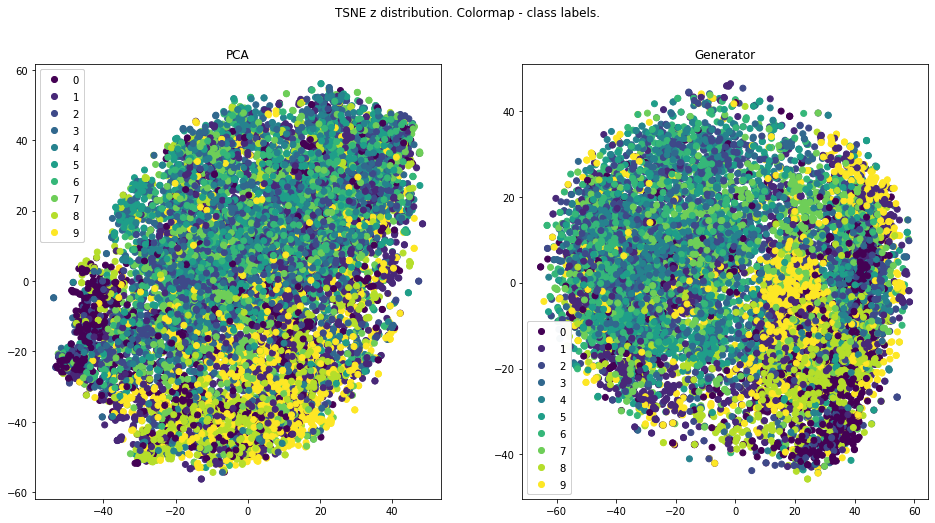

In [ ]:
step = 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('TSNE z distribution. Colormap - class labels.')

# PCA
z_pca = sample_generator.z_dataset[::step, :]
cmap = sample_generator.get_classes()[::step].tolist()
X_embedded = TSNE(n_components=2).fit_transform(z_pca)
scatter1 = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend1 = ax1.legend(*scatter1.legend_elements())
ax1.add_artist(legend1)
ax1.set_title('PCA')

# Generator learned dsitribution
z_model = model.z.weight.detach().cpu().numpy()[::step, :]
X_embedded = TSNE(n_components=2).fit_transform(z_model)
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend2 = ax2.legend(*scatter2.legend_elements())
ax2.add_artist(legend2)
ax2.set_title('Generator')

# fig.tight_layout()
plt.show()

### Expore the latent space

In [ ]:
to_pil = transforms.ToPILImage()

In [ ]:
idx = torch.tensor([1220], dtype=torch.int64).to(device)
fixed_latent = model.z(idx)

In [ ]:
# Find the closest vector
latents = model.z.weight
distance_vectors = latents - fixed_latent
norms = torch.sum(distance_vectors ** 2, dim=1)
argsort = torch.argsort(norms)

In [ ]:
close_idx = torch.tensor(argsort[[0, 1, 2, 3, 5, 6]], dtype=torch.int64).to(device)
classes = sample_generator.get_classes()[close_idx].tolist()

mix_inputs = torch.sum(model.z(close_idx), dim=0) / len(close_idx)
mix_inputs = mix_inputs.unsqueeze(0).to(device)

original_img = [dataset_train[i][1] for i in close_idx]
trained_res = model(idx=close_idx).to('cpu')
mixed_res = model(inputs=mix_inputs).to('cpu')

6


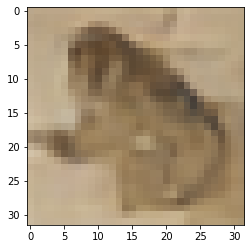

2


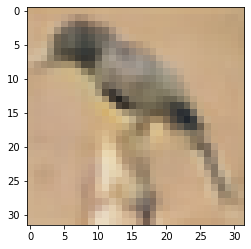

6


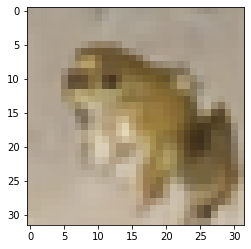

2


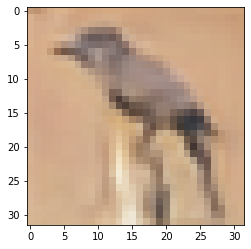

6


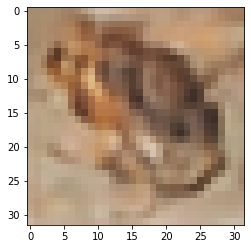

6


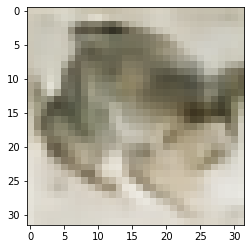

In [ ]:
for label, img in zip(classes, trained_res):
    print(label)
    plt.imshow(to_pil(img))
    plt.show()

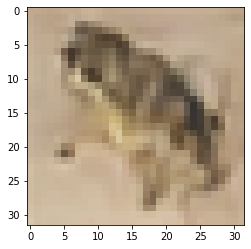

In [ ]:
plt.imshow(to_pil(mixed_res[0]))
plt.show()

## Calculate metrics

#### Models

In [ ]:
# exp_name = 'basic'
# model_path = '/content/drive/MyDrive/GLANN/joint_mnist_models'

# model.load_state_dict(torch.load(os.path.join(model_path, f'{exp_name}_generator_model.pth')))
# flow.load_state_dict(torch.load(os.path.join(model_path, f'{exp_name}_flow_model.pth')))

<All keys matched successfully>

In [ ]:
def mnist_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5, padding='same'),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

def mnist_fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.ReLU(),
        nn.Dropout(p=0.2)
    )

class MNISTModel(nn.Module):
    def __init__(self, n_classes):
        super(MNISTModel, self).__init__()
        self.feature_network = nn.Sequential(
            mnist_conv_block(1, 16),
            mnist_conv_block(16, 32),
            nn.Flatten(),
            mnist_fc_block(7*7*32, 256),
        )
        self.to_logits = nn.Linear(256, n_classes)

    def forward(self, input):
        return self.to_logits(self.feature_network(input))
    
    def features(self, input):
        return self.feature_network(input)

classifier = MNISTModel(10).to(device)
classifier.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/classifiers/mnist_albu_model.pth'))

<All keys matched successfully>

#### Metrics

In [ ]:
def inputs_generator(size):
    normal_sample = torch.randn(size, N_COMPONENTS).to(device)
    fake_lats, _ = flow(normal_sample, rev=True)
    return fake_lats

def calc_classifier_features(generator, dataloader, inputs_generator, classifier):
    real_features = []
    fake_features = []
    fake_probs = []
    gen_device = next(iter(generator.parameters())).device
    for idx, real_img, _ in tqdm(dataloader, leave=False):
        bs = real_img.shape[0]
        if inputs_generator is None:
            idx = idx.long().to(gen_device)
            fake_img = generator(idx=idx).to(device)
        else:
            inputs = torch.nan_to_num(inputs_generator(bs), posinf=1, neginf=-1).to(gen_device)
            if torch.any(torch.isnan(inputs)):
                print(f'NaN samples occured: {inputs}')
            fake_img = generator(inputs=inputs).to(device)
        
        real_img = real_img.to(device)
        
        real_features_batch = classifier.features(real_img)
        real_features.append(real_features_batch.detach().cpu().numpy())   
        
        fake_features_batch = classifier.features(fake_img)
        fake_probs_batch = F.softmax(classifier.to_logits(fake_features_batch), dim=1)
        fake_features.append(fake_features_batch.detach().cpu().numpy())
        fake_probs.append(fake_probs_batch.detach().cpu().numpy())
        
    real_features = np.concatenate(real_features)
    fake_features = np.concatenate(fake_features)
    fake_probs = np.concatenate(fake_probs)

    return (real_features, 
            np.nan_to_num(fake_features, posinf=1, neginf=-1), 
            np.nan_to_num(fake_probs, posinf=0.5, neginf=-0.5))

In [ ]:
fid, inception_score = val_loss(model, train_loader, inputs_generator)
print('FID and IS on Inception v3')
print(f'FID: {fid}\n IS: {inception_score}')

  0%|          | 0/938 [00:00<?, ?it/s]

FID and IS on Inception v3
FID: 13.03388741605675
 IS: 2.4306352138519287


In [ ]:
real_features, fake_features, fake_probs = calc_classifier_features(model, train_loader, inputs_generator, classifier)
fid = ValLoss.calc_fid(real_features, fake_features)
inception_score = ValLoss.calc_is(fake_probs)
print('FID and IS on custom MNIST classifier')
print(f'FID: {fid}\n IS: {inception_score}')

  0%|          | 0/938 [00:00<?, ?it/s]

FID and IS on custom MNIST classifier
FID: 5.011274125724901
 IS: 9.385612487792969


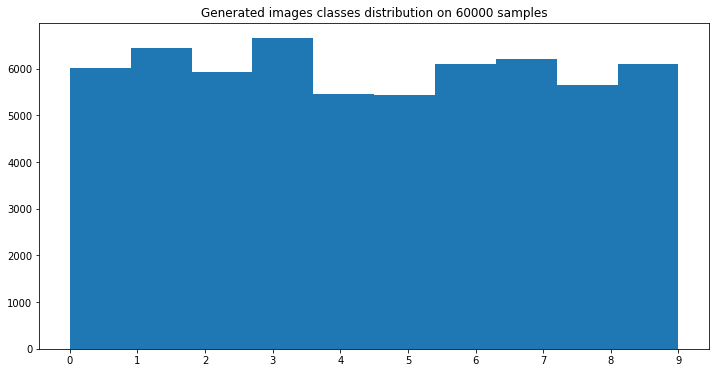

In [ ]:
classes = np.argmax(fake_probs, axis=1)
plt.figure(figsize=(12, 6))
plt.hist(classes, bins=10)
plt.title(f'Generated images classes distribution on {len(classes)} samples')
plt.xticks(np.unique(classes))
plt.show()

### Inference with generator

In [ ]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.dataset import IdxDataset

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
mnist_train = MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True)

In [ ]:
mnist_train = IdxDataset(mnist_train)

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

In [ ]:
N_COMPONENTS = 32
BW_METHOD = 0.1
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [ ]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [ ]:
base_distribution.sample(10).shape

torch.Size([10, 32])

In [ ]:
res = model(inputs=flow.sample(10))

In [ ]:
imgs = []
for tensor_res in res:
    img = inverse_transform(tensor_res)
    imgs.append(img)

In [ ]:
for img in imgs:
    plt.imshow(img)
    plt.show()

#### GLO article inference
Single full-covariance Gaussian fitted into the latents distribution

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



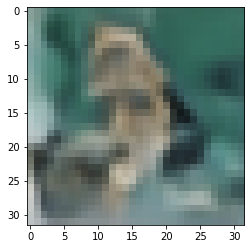

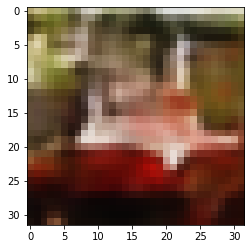

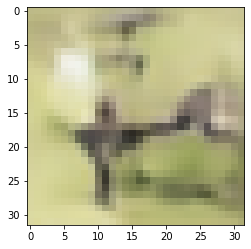

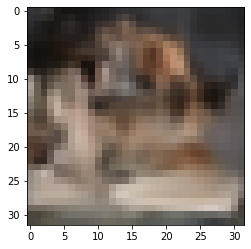

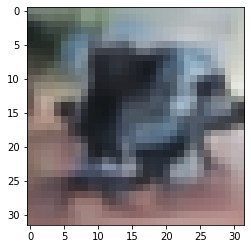

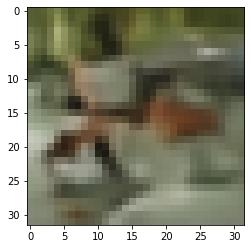

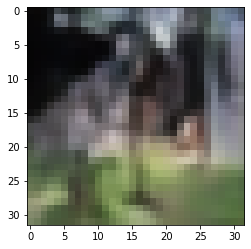

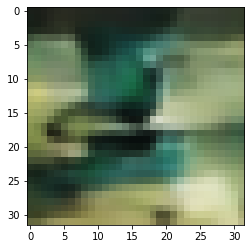

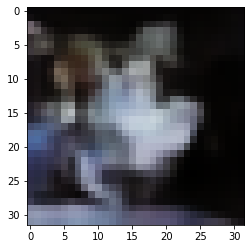

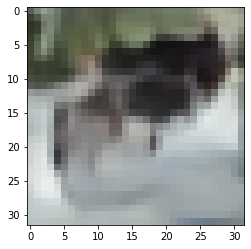

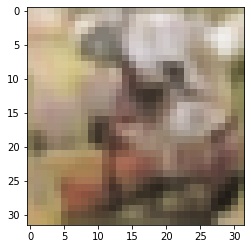

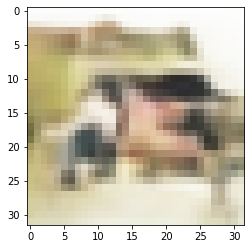

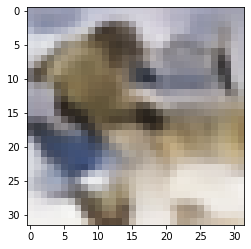

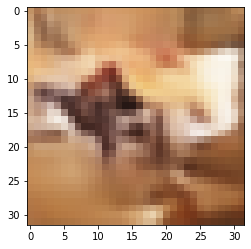

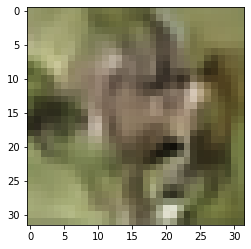

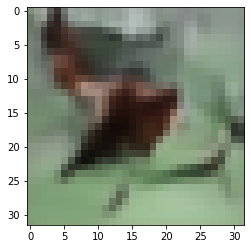

In [ ]:
gm_res = model(inputs=torch.tensor(gm.sample(16)[0], dtype=torch.float).to(device))
for tensor_res in gm_res:
    img = inverse_transform(tensor_res.to('cpu'))
    plt.imshow(img)
    plt.show()